'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


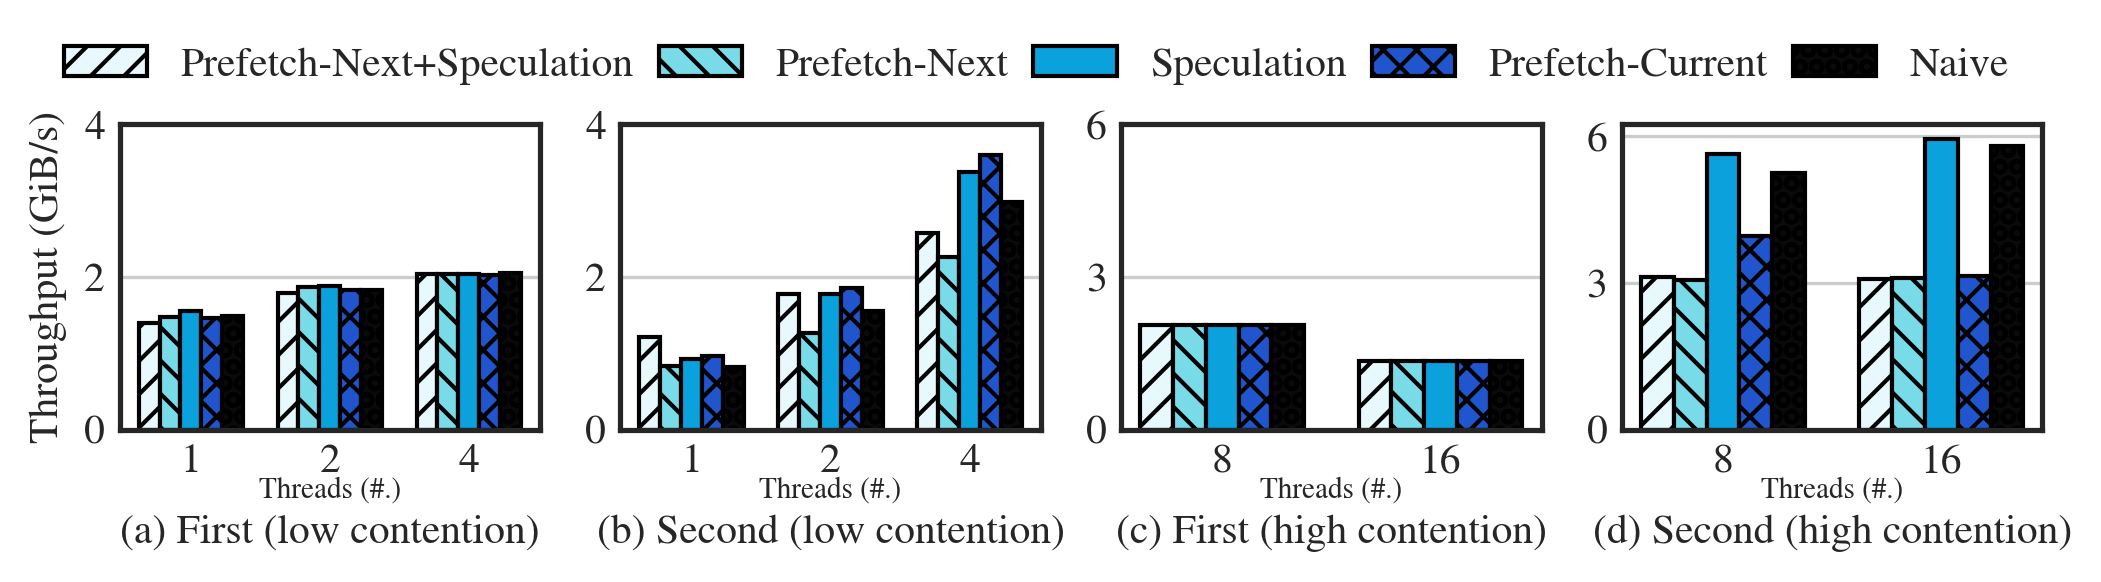

In [58]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
with open("./avg-test-result-in-paper", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(4.5)))
bar_width = 0.15
subfig_titles = ["(a) First (low contention)", "(b) Second (low contention)", "(c) First (high contention)", "(d) Second (high contention)"]
patterns = ['///', '\\\\\\', '', 'XXX', "OOO"]
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#E8F9FD", "#79DAE8", "#0AA1DD", "#2155CD", "#0A0A0A"]
xs = [[1, 2, 3], [1, 2, 3], [4, 5], [4, 5]]

for i in range(4):
    subfig = plt.subplot(1, 4, i + 1)
    x = xs[i]
    x_label = [1, 2, 4] if len(x) == 3 else [8, 16]
    fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
    tot = len(fss) * bar_width
    for idx, fs in enumerate(fss):
        points = []
        for pivot in x:
            point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
            points.append(point)
        plt.bar(points, df[(df['file_system'] == fs) & (df['num_job'] <= max(x_label)) & (df['num_job'] >= min(x_label))]['first_bandwidth(MiB/s)' if i % 2 == 0 else 'second_bandwidth(MiB/s)'] / 1024, width=bar_width, hatch=patterns[idx], edgecolor='black', color=colors[idx])
        
        if i < 2:
            plt.yticks([0, 2, 4])
        else:
            plt.yticks([0, 3, 6])

        plt.xticks(x, labels=x_label)
        if i == 0:
            plt.ylabel('Throughput (GiB/s)')

    # Draw title
    subfig.text(0.5, -0.2, "Threads (#.)", ha='center', va='center', fontsize=7, transform=subfig.transAxes)
    plt.xlabel(subfig_titles[i], labelpad = 8)
            
fig.legend(fss, loc='center', ncol=5, columnspacing = 0.6, bbox_to_anchor=(0.5, 1),)

plt.tight_layout()
plt.savefig("./FIG-Prefetch.pdf", bbox_inches='tight', pad_inches=0)
